# Projeto de Aplicações Avançadas de Instrumentação Biomédica

Em ballet, a pirouette é a realização de um movimento em que o bailarino dá (pelo menos) uma volta completa controlada e apenas numa perna. Este é um dos movimentos mais reconhecíveis de ballet, sendo que grande parte do sucesso do mesmo depende do quão bem equilibrado se encontra o bailarino, ou seja, se este está no "eixo" ou não. 

<div>
<img src="https://www.researchgate.net/profile/Thomas-Schack/publication/254312684/figure/fig2/AS:297819610075138@1448017136417/Pirouette-en-dehors-functional-phases-are-given-above-the-stick-figure-cartoon-basic.png" wdith="600"/>
</div>
<div>
Neste projeto pretende-se utilizar um acelerómetro e um giroscópio para avaliar se uma pirouette se encontra no eixo. Devido à dificuldade em realizar estes movimentos um grande número de vezes, particularmente uma pirouette propositadamente fora do eixo e desiquilibrada numa dada direção, escolheu-se fazer apenas o movimento de relevé inicial. 
</div>

Assim, vamos fazer medições de 4 posições diferentes relacionadas com este tema:
- a primeira posição é o movimento de relevé (Eq).
- a segunda posição é o movimento de relevé com desiquilíbrio acentuado para a frente, de forma a simular a saída do eixo nessa direção (D1).
- a terceira posição é o movimento de relevé com desiquilíbrio acentuado para trás (D2).
- a quarta posição é a classe de exclusão, em que não se realiza nenhum movimento (Ex).

Para a aquisição utilizou-se um metrónomo a 40 bpm para marcar o tempo de cada movimento, sendo que se utilizou 2 batimentos para cada movimento. Nos primeiros segundos da gravação deu-se alguns toques no telemóvel no tempo do metrónomo para mais facilmente se determinar o tamanho da janela e fazer a segmentação do sinal.

Colocou-se o telemóvel na região abdominal, segurado com um cinto, de forma a recolher os dados de acelerómetro e giroscópio no centro de massa.

Para cada posição está-se a considerar então um total de tempo de aquisição de cerca de 66 segundos. Sabemos que apesar de se admitir uma frequência de aquisição específica irão sempre haver algumas variações de medição para medição, e por isso os tamanhos de janela não serão exatamente iguais.

Para a classe de exclusão utilizou-se um maior intervalo de tempo uma vez que esta classe é notoriamente difícil de classificar, consistindo maioritariamente em ruído.

- 60ms (16.67 Hz) - 1100 amostras
- -> 10ms (100 Hz) - 6600 amostras

## Import Libraries

In [20]:
from numpy import loadtxt, zeros, diff, mean, arange, ceil
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import tsfel
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import json
import csv

## Aquisição dos dados

Começa-se por adquirir os dados nos sensores de giroscópio e acelerómetro. Esta parte deverá ser feita no Raspberry PI, apesar de o código também funcionar em casa.

In [ ]:
import time
import json
import socket
import numpy as np


print ('The begin ...')

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    host = "192.168.1.236" #put here the ip address of your mobile
    port = 4244
    
    filename=input("Output filename: ")
    sample=int(input("How many samples: "))
    
    print('Opening socket')
    s.connect((host, port))

    f=open(filename+'.csv', 'w')
    for n in range(sample):
        #time.sleep(0.025)
        data = s.recv(256)
        if data:
            decoded_data = data.decode("utf-8").split("\n")
            for msg in decoded_data:
                try:
                    package = json.loads(msg)
                    #print(package)
                    t=package["accelerometer"]["timestamp"]
                    acc=package["accelerometer"]["value"]
                    gyro=package["gyroscope"]["value"]
                    a = str(t)+','+str(acc[0])+','+str(acc[1])+','+str(acc[2])+','+str(gyro[0])+','+str(gyro[1])+','+str(gyro[2])
                    print(a)
                    f.write(a+'\n')


                except:
                    continue


    f.close()
    s.close()   
    print('socket closed') 


print ('... end')

## Creating a DataFrame

Primeiro de tudo, carregou-se os ficheiros csv com as várias posições como data1, data2, data3, e data4 para DataFrames de forma a mais facilmente se poder visualizar os valores.

In [2]:
#Eu tenho este documento do Jupyter na mesma pasta que os ficheiros csv, 
#se não possivelmente não conseguia fazer assim

#D1 - desiquilíbrio acentuado para a frente
dataD1 = pd.read_csv("D1.csv", header=None)
dataD1.columns = ["Timestamp", "Accx", "Accy", "Accz", "Gyrox", "Gyroy", "Gyroz"]

#D2 - desiquilíbrio acentuado para trás
dataD2 = pd.read_csv("D2.csv", header=None)
dataD2.columns = ["Timestamp", "Accx", "Accy", "Accz", "Gyrox", "Gyroy", "Gyroz"]

#Eq - equilíbrio
dataEq = pd.read_csv("Eq.csv", header=None)
dataEq.columns = ["Timestamp", "Accx", "Accy", "Accz", "Gyrox", "Gyroy", "Gyroz"]

#Ex - exclusão
dataEx = pd.read_csv("Ex.csv", header=None)
dataEx.columns = ["Timestamp", "Accx", "Accy", "Accz", "Gyrox", "Gyroy", "Gyroz"]


In [3]:
dataD1

,Timestamp,Accx,Accy,Accz,Gyrox,Gyroy,Gyroz
0,1.627930e+15,0.320823,9.737218,-1.474828,-0.014381,0.001065,0.002663
1,1.627930e+15,0.380678,9.694122,-1.537078,-0.011185,-0.023968,0.015979
2,1.627930e+15,0.359130,9.701305,-1.419762,-0.036219,0.011185,-0.007989
3,1.627930e+15,0.349553,9.722853,-1.376666,-0.039415,0.041013,-0.025034
4,1.627930e+15,0.476446,9.698911,-1.443704,-0.046872,-0.021838,0.002663
...,...,...,...,...,...,...,...
1587,1.628010e+15,-0.102951,9.684546,3.143587,0.149670,0.099070,-0.028762
1588,1.628010e+15,0.603339,9.981427,2.834735,0.129430,0.099602,0.018109
1589,1.628010e+15,0.493206,9.174581,3.038242,0.136886,0.178964,-0.060187
1590,1.628010e+15,0.675165,9.828198,2.932897,0.183758,0.102798,0.001065


## MQTT

Nesta secção está feita a parte relativa à forma como se vai passar as coisas pelo mqtt broker. Sabemos que se tem de passar os dados em string pelo broker, por isso teve de se arranjar forma de manipular os dados para que se consiga depois também recuperar os mesmos no Subscriber. 

Assim, começa-se por transformar o csv criado pelo Raspberry numa DataFrame.

In [12]:
data_mqtt = pd.read_csv("teste_proj.csv", header=None)
data_mqtt.columns = ["Timestamp", "Accx", "Accy", "Accz", "Gyrox", "Gyroy", "Gyroz"]

Depois, transformou-se apenas os valores da Dataframe anterior numa lista de listas, de forma a não haver problemas com os indexs.

In [13]:
lista_df2= data_mqtt.values.tolist()

In [14]:
classe =2
data_mqtt["Classe"] =classe

In [15]:
lista_df= data_mqtt.values.tolist()
#lista_df

Agora, passa-se a lista para uma string, sendo que é indo que vai ser passado pelo mqtt broker.

In [16]:
string_lista=str(lista_df)

Com o json vai-se voltar de string para uma lista, que é depois de novo convertida numa DataFrame. Comparando com a anterior percebe-se que é exatamente igual.

In [17]:
res = json.loads(string_lista)

In [18]:
last_test = pd.DataFrame(res)
last_test.columns = ["Timestamp", "Accx", "Accy", "Accz", "Gyrox", "Gyroy", "Gyroz", "Classe"]
#last_test

Apenas de forma a poder aproveitar o trabalho anterior realizado para esta mesma disciplina, manteve-se o código do subscriber que escrevia os valores da lista recebida como um ficheiro csv, sendo que o ficheiro relativo à página do streamlit vai transformar esse ficheiro csv numa dataframe, de onde são retirados os dados para a visualização nos gráficos.

In [21]:
with open("outro_teste.csv", "w") as f:
    write = csv.writer(f)
    write.writerows(res)

In [22]:
data_Sub = pd.read_csv("outro_teste2.csv", header=None)
data_Sub.columns = ["Timestamp", "Accx", "Accy", "Accz", "Gyrox", "Gyroy", "Gyroz", "Classe"]
data_Sub1=data_Sub.drop("Timestamp", axis=1)

In [23]:
data_Acc = data_Sub1[["Accx","Accy","Accz"]]
#data_Acc

In [24]:
#data_Sub1

In [25]:
predict = [[0,1,2,3],["Classe de exclusão", "Desiquílibrio para a frente", "Desiquilíbrio para trás", "Equilíbrio"]]
class_mov=predict[0]
class_mov

[0, 1, 2, 3]

In [26]:
classe_df = pd.DataFrame(predict)
cl=classe_df.T
cl.columns = ["classe", "pos"]
cl

,classe,pos
0,0,Classe de exclusão
1,1,Desiquílibrio para a frente
2,2,Desiquilíbrio para trás
3,3,Equilíbrio


In [27]:
str(cl["pos"][0])

'Classe de exclusão'

### Plotting the data

Começámos por visualizar de forma rápida alguns dos gráficos possíveis a partir das dataframes criadas anteriormente. Como não sabemos como converter o timestamp, utilizou-se o index, com as amostras em x.

In [28]:
dataD1["Timestamp"]

0       1.627930e+15
1       1.627930e+15
2       1.627930e+15
3       1.627930e+15
4       1.627930e+15
            ...     
1587    1.628010e+15
1588    1.628010e+15
1589    1.628010e+15
1590    1.628010e+15
1591    1.628010e+15
Name: Timestamp, Length: 1592, dtype: float64

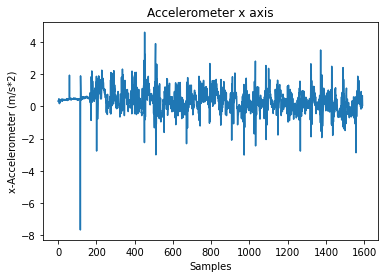

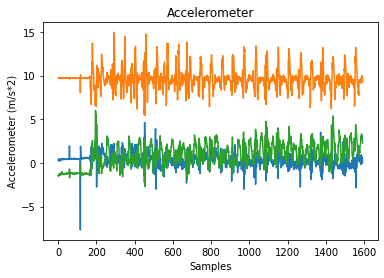

In [29]:
plt.plot(dataD1.index, dataD1.Accx)
plt.xlabel('Samples') 
plt.ylabel('x-Accelerometer (m/s*2)') 
plt.title('Accelerometer x axis') 
plt.show()

plt.plot(dataD1.index, dataD1.Accx)
plt.plot(dataD1.index, dataD1.Accy)
plt.plot(dataD1.index, dataD1.Accz)
plt.xlabel('Samples') 
plt.ylabel('Accelerometer (m/s*2)') 
plt.title('Accelerometer') 
plt.show()

## Segmentação dos dados

Tendo em conta que se fez uma única gravação para cada uma das quatro posições a serem avaliadas, teve-se que começar por segmentar cada uma das dataframes existentes.

#### Dataframe D1 - desiquilíbrio acentuado para a frente

Começou-se por ver o plot com as linhas onde se irão separar as várias janelas, de forma visualizar a segmentação.

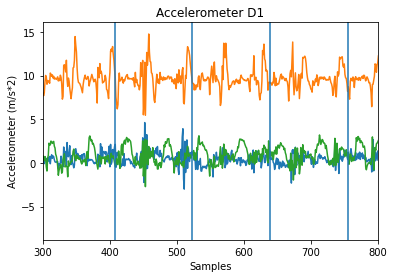

In [30]:
plt.plot(dataD1.index, dataD1.Accx)
plt.plot(dataD1.index, dataD1.Accy)
plt.plot(dataD1.index, dataD1.Accz)
plt.xlabel('Samples') 
plt.ylabel('Accelerometer (m/s*2)') 
plt.title('Accelerometer D1') 
#step de 58 entre cada beat do metrónomo. Ou seja, as janelas vão estar de 116 em 116 amostras
#Temos então 12 repetições da posição D1, começando entre 175 e 291, 291 e 407, etc até 1451 e 1567. 
plt.axvline(59) 
plt.axvline(117)
plt.axvline(175)
plt.axvline(291)
plt.axvline(407)
plt.axvline(523)
plt.axvline(639)
plt.axvline(755)
plt.axvline(871)
plt.axvline(987)
plt.axvline(1103)
plt.axvline(1219)
plt.axvline(1335)
plt.axvline(1451)
plt.axvline(1567)
plt.xlim(300,800)
plt.show()

Depois, retirou-se os primeiros dados, correspondentes ao período sem nada, apenas a marcar o ritmo do metrónomo.

Neste passo, retirou-se em todas as dataframes resultantes (D1_menor neste caso) a coluna do Timestamp, visto que para a função que se irá utilizar só precisamos das amostras e da frequência de amostragem.

In [31]:
# Cortar o dataset de 175 amostras até 1567, ficando com 1392 amostras. Dividindo por 116 temos os 12 grupos
D1_menor=dataD1.loc[175:1567]
D1_menor=D1_menor.drop("Timestamp", axis=1)
#D1_menor

Verificou-se quais seriam então os limites das 12 janelas para o dataset D1, com um ciclo 

In [32]:
# Vamos ter os dividers em: 175, 291, 407, 523, 639,755, 871, 987, 1103, 1219, 1335, 1451, 1567

t_D1 = [i for i in D1_menor.index if ((i-D1_menor.index[0]) % 116) == 0]
print(t_D1)

[175, 291, 407, 523, 639, 755, 871, 987, 1103, 1219, 1335, 1451, 1567]


#### Dataframe D2 - desiquilíbrio acentuado para atrás

Repetiu-se então o procedimento adotado anteriormente para as posições D2, Eq e Ex.

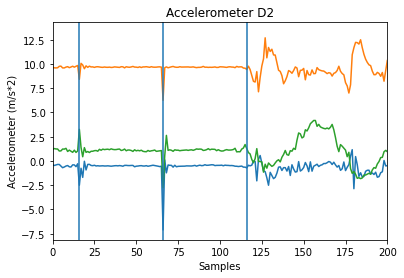

In [79]:
plt.plot(dataD2.index, dataD2.Accx)
plt.plot(dataD2.index, dataD2.Accy)
plt.plot(dataD2.index, dataD2.Accz)
plt.xlabel('Samples') 
plt.ylabel('Accelerometer (m/s*2)') 
plt.title('Accelerometer D2') 

#step de 50, janelas de 100 amostras
#Temos então 14 repetições da posição D2, começando entre 116 e 216, etc até 1416 e 1516

# Vamos ter os dividers em: 116, 216, 316,416, 516, 616, 716, 816, 916, 1016, 1116, 1216, 1316, 1416, 1516
plt.axvline(16)
plt.axvline(66)
plt.axvline(116)
plt.axvline(216)
plt.axvline(316)
plt.axvline(416)
plt.axvline(516)
plt.axvline(616)
plt.axvline(716)
plt.axvline(816)
plt.axvline(916)
plt.axvline(1016)
plt.axvline(1116)
plt.axvline(1216)
plt.axvline(1316)
plt.axvline(1416)
plt.axvline(1516)

plt.xlim(0,200)
plt.show()

In [34]:
# Cortar o dataset a partir de 116 amostras, ficando com 14 grupos
D2_menor=dataD2.loc[116:]
D2_menor=D2_menor.drop("Timestamp", axis=1)
#D2_menor

In [35]:
# Vamos ter os dividers em: 116, 216, 316,416, 516, 616, 716, 816, 916, 1016, 1116, 1216, 1316, 1416, 1516

t_D2 = [i for i in D2_menor.index if ((i-D2_menor.index[0]) % 100) == 0]
print(t_D2)

[116, 216, 316, 416, 516, 616, 716, 816, 916, 1016, 1116, 1216, 1316, 1416, 1516]


#### Dataframe Eq - equilíbrio

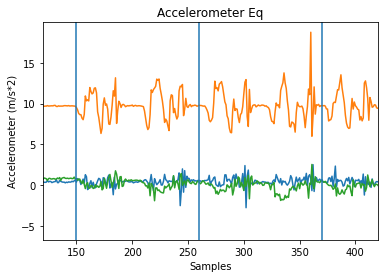

In [78]:
plt.plot(dataEq.index, dataEq.Accx)
plt.plot(dataEq.index, dataEq.Accy)
plt.plot(dataEq.index, dataEq.Accz)
plt.xlabel('Samples') 
plt.ylabel('Accelerometer (m/s*2)') 
plt.title('Accelerometer Eq') 
#step de 55, janelas de 110 amostras
#Temos então 12 repetições da posição Eq, começando entre 150 e 260, etc até 1360 e 1470

# Vamos ter os dividers em: 150, 260, 370, 480, 590, 700, 810, 920, 1030, 1140, 1250, 1360, 1470

plt.axvline(150)
plt.axvline(260)
plt.axvline(370)
plt.axvline(480)
plt.axvline(590)
plt.axvline(700)
plt.axvline(810)
plt.axvline(920)
plt.axvline(1030)
plt.axvline(1140)
plt.axvline(1250)
plt.axvline(1360)
plt.axvline(1470)

plt.xlim(120,420)
plt.show()

In [37]:
# Cortar o dataset de 150 amostras ao final, ficando com 1375 amostras. Dividindo por 110 temos os 12 grupos
Eq_menor=dataEq.loc[150:]
Eq_menor=Eq_menor.drop("Timestamp", axis=1)
#Eq_menor

In [38]:
# Vamos ter os dividers em: 150, 260, 370, 480, 590, 700, 810, 920, 1030, 1140, 1250, 1360, 1470

t_Eq = [i for i in Eq_menor.index if ((i-Eq_menor.index[0]) % 110) == 0]
print(t_Eq)

[150, 260, 370, 480, 590, 700, 810, 920, 1030, 1140, 1250, 1360, 1470]


#### Dataframe Ex - classe de exclusão

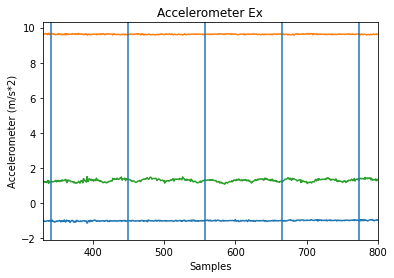

In [39]:
plt.plot(dataEx.index, dataEx.Accx)
plt.plot(dataEx.index, dataEx.Accy)
plt.plot(dataEx.index, dataEx.Accz)
plt.xlabel('Samples') 
plt.ylabel('Accelerometer (m/s*2)') 
plt.title('Accelerometer Ex') 
#step de 54, janelas de 108 amostras
#Temos então 25 repetições da posição Ex, começando entre 342 e 450, etc até 2934 e 3042.

# Vamos ter os dividers em: 342, 450, 558, 666, 774, 882, 990, 1098, 1206, 1314, 1422, 1530, 1638, etc
plt.axvline(72)
plt.axvline(126)
plt.axvline(180)
plt.axvline(234)
plt.axvline(288)
#--------------------
plt.axvline(342) 
plt.axvline(450)
plt.axvline(558)
plt.axvline(666)
plt.axvline(774)
plt.axvline(882)
plt.axvline(990)
plt.axvline(1098)
plt.axvline(1206)
plt.axvline(1314)
plt.axvline(1422)
plt.axvline(1530)
plt.axvline(1638)
plt.axvline(1746)

plt.xlim(330,800)
plt.show()

In [40]:
# Cortar o dataset a partir de 342 amostras. Dividindo por 108 temos os 25 grupos
Ex_menor=dataEx.loc[342:]
Ex_menor=Ex_menor.drop("Timestamp", axis=1)
#Ex_menor

In [41]:
# Vamos ter os dividers em: 342, 450, 558, 666, 774, 882, 990, 1098, 1206, 1314, 1422, 1530, 1638, etc

t_Ex = [i for i in Ex_menor.index if ((i-Ex_menor.index[0]) % 108) == 0]
print(t_Ex)

[342, 450, 558, 666, 774, 882, 990, 1098, 1206, 1314, 1422, 1530, 1638, 1746, 1854, 1962, 2070, 2178, 2286, 2394, 2502, 2610, 2718, 2826, 2934, 3042]


## Extração de características

Tendo já os dados iniciais com o número e o valor das janelas definidas, de seguida tem de se fazer a extração de características, que vão depois ser dadas aos modelos de classsificação.

Começou-se por fazer duas listas, uma de features e outra de labels, que vão ser preenchidas com os dados relativos a cada janela dos vários datasets.

Tendo em conta que aqui estamos a extrair 5 features (Mediana, Média, Máximo, Mínimo, Desvio Padrão) para cada uma das 6 colunas das DataFrames (Acelerómetro e Giroscópio xyz), vamos ter 30 colunas resultantes (31, depois de adicionada a coluna com as classes).

Neste passo, retirou-se em todas as dataframes resultantes a coluna do Timestamp, visto que todas as características neste ponto são de natureza estatística, não necessitando do tempo.

In [42]:
features = []

labels = []

#Para o Desiquilíbrio D1 estamos a associar uma label 1
for p in range(len(t_D1)-1):
    new_D1_df = dataD1.drop("Timestamp", axis=1)[t_D1[p]:t_D1[p+1]]
    w_features_list = [i for j in [new_D1_df.median(axis=0).tolist(), new_D1_df.mean(axis=0).tolist(), new_D1_df.max(axis=0).tolist(),new_D1_df.min(axis=0).tolist(),new_D1_df.std(axis=0).tolist()]for i in j]
    features.append(w_features_list)
    labels.append(1)

#Para o Desiquilíbrio D2 estamos a associar uma label 2
for p in range(len(t_D2)-1):
    new_D2_df = dataD2.drop("Timestamp", axis=1)[t_D2[p]:t_D2[p+1]]
    w_features_list = [i for j in [new_D2_df.median(axis=0).tolist(), new_D2_df.mean(axis=0).tolist(), new_D2_df.max(axis=0).tolist(), new_D2_df.min(axis=0).tolist(), new_D2_df.std(axis=0).tolist()]for i in j]
    features.append(w_features_list)
    labels.append(2)
    
#Para o Equilíbrio Eq estamos a associar uma label 3
for p in range(len(t_Eq)-1):
    new_Eq_df = dataEq.drop("Timestamp", axis=1)[t_Eq[p]:t_Eq[p+1]]
    w_features_list = [i for j in [new_Eq_df.median(axis=0).tolist(), new_Eq_df.mean(axis=0).tolist(), new_Eq_df.max(axis=0).tolist(), new_Eq_df.min(axis=0).tolist(), new_Eq_df.std(axis=0).tolist()]for i in j]
    features.append(w_features_list)
    labels.append(3)

#Para a classe de exclusão Ex, estamos a associar uma label0
for p in range(len(t_Ex)-1):
    new_Ex_df = dataEx.drop("Timestamp", axis=1)[t_Ex[p]:t_Ex[p+1]]
    w_features_list = [i for j in [new_Ex_df.median(axis=0).tolist(), new_Ex_df.mean(axis=0).tolist(), new_Ex_df.max(axis=0).tolist(), new_Ex_df.min(axis=0).tolist(), new_Ex_df.std(axis=0).tolist()]for i in j]
    features.append(w_features_list)
    labels.append(0)

In [43]:
#print(features)

In [44]:
#Podemos verificar que se está a fazer o número certo para cada uma (ex. 24 janelas para a posição D1)
print(labels)
print(len(labels))
print(len(features))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
63
63


In [291]:
#dataD1.drop("Timestamp", axis=1)[175:291]

In [292]:
#Só para verificar que o que pus na DataFrame a seguir está bem
#dataD1.drop("Timestamp", axis=1)[175:291].median(axis=0)

In [293]:
#dataD1.drop("Timestamp", axis=1)[175:291].mean(axis=0)

Aqui fica a dataFrame com todas as features retiradas em cada janela e com a classe correspondente no final

In [45]:
df_features = pd.DataFrame(features, columns=["Median_Accx", "Median_Accy", "Median_Accz", "Median_Gyrx", "Median_Gyry", "Median_Gyrz", "Mean_Accx", "Mean_Accy", "Mean_Accz", "Mean_Gyrx", "Mean_Gyry", "Mean_Gyrz", "Max_Accx", "Max_Accy", "Max_Accz", "Max_Gyrx", "Max_Gyry", "Max_Gyrz", "Min_Accx", "Min_Accy", "Min_Accz", "Min_Gyrx", "Min_Gyry", "Min_Gyrz", "std_Accx", "std_Accy", "std_Accz", "std_Gyrx", "std_Gyry", "std_Gyrz"])

df_features["Classe"]=labels
df_features

,Median_Accx,Median_Accy,Median_Accz,Median_Gyrx,Median_Gyry,Median_Gyrz,Mean_Accx,Mean_Accy,Mean_Accz,Mean_Gyrx,...,Min_Gyrx,Min_Gyry,Min_Gyrz,std_Accx,std_Accy,std_Accz,std_Gyrx,std_Gyry,std_Gyrz,Classe
0,0.776918,9.581595,0.404620,-0.041279,0.006658,0.000799,0.736795,9.623163,0.879972,-0.020456,...,-0.686030,-0.772317,-0.537426,0.719038,1.182029,1.495022,0.255902,0.242156,0.100556,1
1,0.511162,9.654618,0.509965,0.030626,-0.013316,-0.028496,0.584887,9.890323,0.636197,0.007567,...,-0.350472,-0.406398,-0.399474,0.655759,1.568158,0.949294,0.156191,0.158206,0.146078,1
2,0.511162,9.633071,0.568623,-0.015180,-0.035953,0.007989,0.582204,9.684897,0.783564,-0.014914,...,-0.887898,-0.478836,-0.667388,1.055878,1.492914,1.135121,0.234329,0.184909,0.146463,1
3,0.289698,9.476250,1.006762,0.002131,-0.002663,0.001598,0.315312,9.678189,1.021994,-0.000574,...,-0.651942,-0.423443,-0.347809,0.658011,1.277280,0.950189,0.199593,0.185478,0.124421,1
4,0.363919,9.570821,1.024718,0.063117,-0.020773,0.004261,0.330111,9.694453,1.010229,-0.000441,...,-0.815460,-0.321710,-0.442085,0.647650,1.131149,0.959684,0.225581,0.161659,0.127973,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,-0.963666,9.603143,1.405396,0.002663,0.001065,0.000000,-0.962935,9.600993,1.405818,0.000108,...,-0.051665,-0.022903,-0.010120,0.029462,0.017790,0.064702,0.014743,0.008911,0.003282,0
59,-0.991200,9.591172,1.448492,0.002131,0.001332,0.001332,-0.989005,9.588334,1.459909,0.001558,...,-0.025566,-0.048470,-0.013848,0.029083,0.020112,0.072995,0.011243,0.011019,0.003736,0
60,-0.979228,9.591172,1.458069,-0.001065,-0.001065,0.000533,-0.980403,9.588445,1.460130,-0.002052,...,-0.036219,-0.021305,-0.009587,0.025095,0.019177,0.063746,0.009155,0.007769,0.002707,0
61,-0.985214,9.574412,1.546654,-0.002663,0.000266,0.000533,-0.985879,9.574147,1.538585,0.000113,...,-0.026099,-0.020773,-0.007989,0.026738,0.017025,0.071224,0.012623,0.009518,0.003306,0


# Teste

Esta parte do teste na verdade é a correspondente ao que se acabou por fazer na realidade. Tudo o que está a seguir desta secção foram coisas feitas antes, mas que não se usaram no final.

### Feature Selection

Para se selecionar as (supostas) melhores características de entre as retiradas anteriormente, utilizou-se o featwiz, com um limite de correlação de 90%.

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.9
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (63, 31)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
        No variables were rem

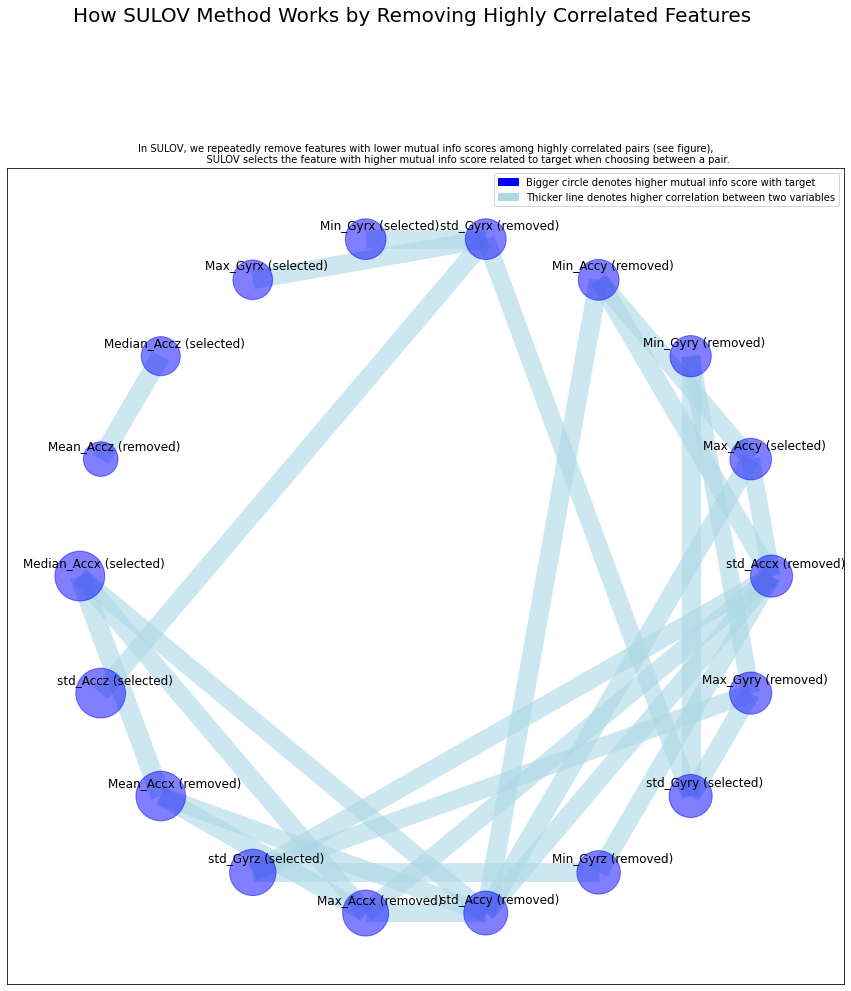

Time taken for SULOV method = 0 seconds
    Adding 0 categorical variables to reduced numeric variables  of 20
Final list of selected 20 vars after SULOV = ['Max_Accz', 'Max_Gyrz', 'Mean_Accy', 'Mean_Gyrx', 'Mean_Gyry', 'Mean_Gyrz', 'Median_Accy', 'Median_Gyrx', 'Median_Gyry', 'Median_Gyrz', 'Min_Accx', 'Min_Accz', 'Median_Accx', 'std_Accz', 'std_Gyrz', 'std_Gyry', 'Max_Accy', 'Min_Gyrx', 'Max_Gyrx', 'Median_Accz']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 20 
    Taking top 7 features per iteration...
    XGBoost version using 1.7.2 as tree method: hist
Number of booster rounds = 100
        using 20 variables...
          

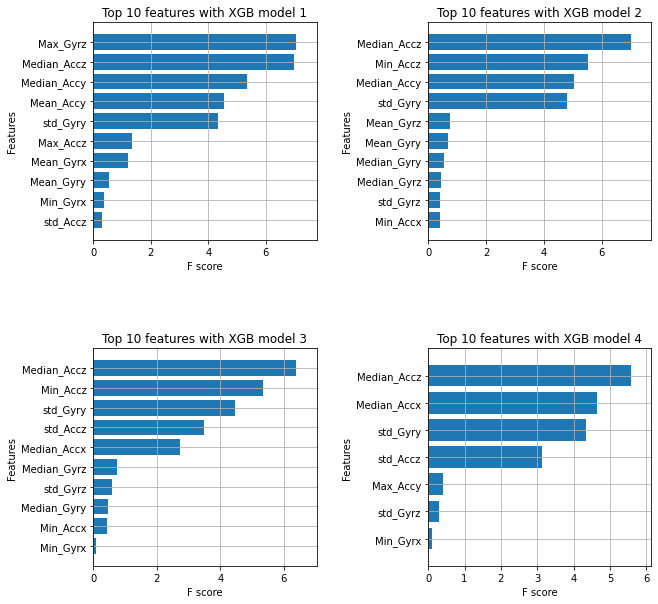

    Completed XGBoost feature selection in 0 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 10 important features:
['Max_Gyrz', 'Median_Accz', 'Median_Accy', 'Mean_Accy', 'std_Gyry', 'Max_Accz', 'Mean_Gyrx', 'Min_Accz', 'std_Accz', 'Median_Accx']
Total Time taken for featurewiz selection = 1 seconds
Output contains a list of 10 important features and a train dataframe


In [83]:
import featurewiz as FW
target="Classe"
features_final, train = FW.featurewiz(dataname=df_features, target=target, corr_limit=0.90, verbose=2, sep=",",
                                     header=0, test_data='', feature_engg='', category_encoders='',
                                     dask_xgboost_flag=False, nrows=None)

Assim, podemos ver que ficamos com uma lista de 10 features que serão as melhores. A dataframe train é a que contém apenas os dados relativos a estas 10 características, enquanto que a DataFrame df_features contém os dados com todas as features. Iremos testar os dois casos para o X_tt de forma a perceber qual a diferenteça entre os dois.

In [85]:
print(features_final)

['Max_Gyrz', 'Median_Accz', 'Median_Accy', 'Mean_Accy', 'std_Gyry', 'Max_Accz', 'Mean_Gyrx', 'Min_Accz', 'std_Accz', 'Median_Accx']


##### Dados Para Teste

Aqui vamos extrair novos dados de forma a poder prever a classe final com o modelo já treinado. Assim, ddd vai corresponder à dataFrame com o conjunto completo de features retiradas, enquanto que ddd_t vai ser o conjunto das 10 melhores features.
Neste caso, estamos a ver o movimento D1, com a classe correspondente [1].

In [97]:
data_t2 = pd.read_csv("D1_1.csv", header=None)
data_t2.columns = ["Timestamp", "Accx", "Accy", "Accz", "Gyrox", "Gyroy", "Gyroz"]
data_t2=data_t2.drop("Timestamp", axis=1)
data_t2

,Accx,Accy,Accz,Gyrox,Gyroy,Gyroz
0,1.448492,9.255983,-2.252944,0.022602,0.025656,-0.011606
1,1.374272,9.387665,-2.303222,0.026267,0.027489,-0.013439
2,1.551443,9.380483,-2.319981,0.009774,0.003665,0.000611
3,1.582567,9.437943,-2.331953,-0.007330,-0.025656,0.010996
4,1.582567,9.399636,-2.367866,-0.002443,-0.031765,0.007330
...,...,...,...,...,...,...
85,1.697489,9.548077,-1.663970,0.032987,-0.040317,-0.001222
86,1.563414,9.598354,-1.565808,0.018937,0.001833,-0.018937
87,1.637634,9.526528,-1.577779,0.043371,0.006109,-0.023213
88,1.601721,9.485827,-1.666364,0.052534,0.025045,-0.024435


In [98]:
w_features_list = [i for j in [data_t2.median(axis=0).tolist(), data_t2.mean(axis=0).tolist(), data_t2.max(axis=0).tolist(),data_t2.min(axis=0).tolist(),data_t2.std(axis=0).tolist()]for i in j]
ddd = pd.DataFrame(w_features_list).T
ddd.columns=["Median_Accx", "Median_Accy", "Median_Accz", "Median_Gyrx", "Median_Gyry", "Median_Gyrz", "Mean_Accx", "Mean_Accy", "Mean_Accz", "Mean_Gyrx", "Mean_Gyry", "Mean_Gyrz", "Max_Accx", "Max_Accy", "Max_Accz", "Max_Gyrx", "Max_Gyry", "Max_Gyrz", "Min_Accx", "Min_Accy", "Min_Accz", "Min_Gyrx", "Min_Gyry", "Min_Gyrz", "std_Accx", "std_Accy", "std_Accz", "std_Gyrx", "std_Gyry", "std_Gyrz"]
ddd_f=ddd[features_final]
ddd_f

,Max_Gyrz,Median_Accz,Median_Accy,Mean_Accy,std_Gyry,Max_Accz,Mean_Gyrx,Min_Accz,std_Accz,Median_Accx
0,0.320093,-1.159991,9.473856,9.524507,0.17422,6.033388,-0.008511,-2.588132,2.347806,1.556231


In [99]:
ddd

,Median_Accx,Median_Accy,Median_Accz,Median_Gyrx,Median_Gyry,Median_Gyrz,Mean_Accx,Mean_Accy,Mean_Accz,Mean_Gyrx,...,Min_Accz,Min_Gyrx,Min_Gyry,Min_Gyrz,std_Accx,std_Accy,std_Accz,std_Gyrx,std_Gyry,std_Gyrz
0,1.556231,9.473856,-1.159991,0.023518,0.004887,-0.00672,1.492173,9.524507,-0.174005,-0.008511,...,-2.588132,-0.9951,-0.315817,-0.332311,0.680753,1.469687,2.347806,0.323992,0.17422,0.089181


##### Teste e Treino do Modelo

É nesta parte que podemos decidir se queremos usar todas as características, ou apenas as 10 melhores, conforme deixarmos comentado o X_tt relativo à DataFrame train (10 características), ou o relativo a df_features (todas).

In [100]:
y_tt=df_features["Classe"]
#X_tt=train.drop(columns="Classe")
X_tt=df_features.drop(columns="Classe")

In [101]:
X_traint, X_testt, y_traint, y_testt = train_test_split(X_tt, y_tt, test_size=0.33, random_state=42)

Aqui veremos de forma geral a performance dos classificadores:
- Support Vector Classification (SVC)
- Naive Bayes
- Decision Tree
- Random Forest

In [102]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [103]:
models = [("Support Vector Classification", SVC()), ("Naive Bayes", GaussianNB()),("Decision trees", DecisionTreeClassifier()),("Random Forest", RandomForestClassifier())]

In [104]:
from sklearn.model_selection import cross_val_score
def classifiermetrics(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    
    train_score = classifier.score(X_train, y_train)
    test_score = classifier.score(X_test, y_test)
    
    kfold_score = cross_val_score(classifier, X_train, y_train)
    mean = np.mean(kfold_score)
    std = np.std(kfold_score)
    
    return {"Train Score" : train_score, "Test Score" : test_score, "mean" : mean, "standard deviation" : std}

In [105]:
warnings.filterwarnings("ignore")
df = pd.DataFrame()
for name, model in models:
    d = classifiermetrics(model, X_traint, y_traint, X_testt, y_testt)
    d["clf name"] = name
    df = df.append(d, ignore_index = True)
print("           Teste e Train Scores com as 30 features")
df

           Teste e Train Scores com as 30 features


,Train Score,Test Score,mean,standard deviation,clf name
0,0.857143,0.714286,0.858333,0.040635,Support Vector Classification
1,1.000000,1.000000,0.955556,0.054433,Naive Bayes
2,1.000000,0.761905,0.975000,0.050000,Decision trees
3,1.000000,1.000000,1.000000,0.000000,Random Forest


Podemos ver que de forma geral os classificadores estão bastante overfit. Por curiosidade tentou ver-se qual o resultado de um voting classifier, sendo que novamente ficou completamente overfit.

In [108]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[("Support Vector Classification", SVC()), 
                                          ("Naive Bayes", GaussianNB()),
                                          ("Decision trees", DecisionTreeClassifier()),
                                          ("Random Forest", RandomForestClassifier())], voting='hard')

voting_clf.fit(X_traint, y_traint)
vclf_train_score = voting_clf.score(X_traint, y_traint)
vclf_test_score = voting_clf.score(X_testt, y_testt)

print(vclf_train_score)
print(vclf_test_score)

1.0
1.0


### Modelos

#### Decision Tree

Começando pela Decision Tree, tentou encontrar-se alguns critérios para uma melhor classificação por este classificador.

In [124]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 50, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
criterion=['gini', 'entropy', 'log_loss']

param = {'criterion': criterion, 
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rfc = DecisionTreeClassifier()
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = param, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)

rfc_random.fit(X_traint, y_traint)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 14, 18, 23, 27, 32,
                                                      36, 41, 45, 50, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, verbose=2)

In [125]:
rfc_random.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 14,
 'criterion': 'entropy'}

In [137]:
#model= DecisionTreeClassifier(max_depth=5).fit(X_traint, y_traint)
model= DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=2, max_features ='log2', max_depth=27, criterion='entropy').fit(X_traint, y_traint)
y_pred_test = model.predict(X_testt)
y_pred_train = model.predict(X_traint)

In [138]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

acc_train =  accuracy_score(y_traint,y_pred_train)
acc_test =  accuracy_score(y_testt,y_pred_test)

print('Train Accuracy: %.3f ' % acc_train)
print('Test Accuracy : %.3f' % acc_test)

Train Accuracy: 0.952 
Test Accuracy : 0.905


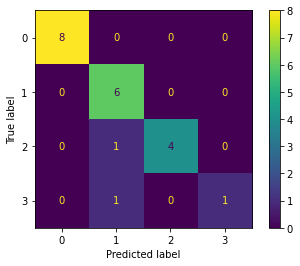

In [139]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_testt, y_testt)  

In [140]:
predictions = model.predict(ddd)

print("Resultado", predictions)

Resultado [1]


#### Random Forest

In [141]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 600, num = 100)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion=['gini', 'entropy', 'log_loss']

param = {'n_estimators': n_estimators, 'criterion': criterion, 
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc = RandomForestClassifier()
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = param, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)

rfc_random.fit(X_traint, y_traint)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 14, 18, 23, 27, 32,
                                                      36, 41, 45, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 204, 208, 212,
                                                         216, 220, 224, 228,
                                                         232, 236, 240, 244,
                                                         248, 252, 256, 260,
                                                         264, 268, 272, 276,
                                                         280, 284, 288, 292,
                                                         296, 301, 305, 309,
                                                         313, 317, ...]},
                   random_state=42, verbose=2)

In [142]:
rfc_random.best_params_

{'n_estimators': 478,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 27,
 'criterion': 'gini',
 'bootstrap': False}

In [172]:
model2= RandomForestClassifier(n_estimators=10, criterion="entropy", max_depth=10, max_features=3).fit(X_traint, y_traint)
#model2= RandomForestClassifier(n_estimators=284, criterion="gini", min_samples_split=10, min_samples_leaf=2, max_depth=27, max_features="auto", bootstrap=False).fit(X_traint, y_traint)
y_pred_test = model2.predict(X_testt)
y_pred_train = model2.predict(X_traint)

In [173]:
acc_train =  accuracy_score(y_traint,y_pred_train)
acc_test =  accuracy_score(y_testt,y_pred_test)

print('Train Accuracy: %.3f ' % acc_train)
print('Test Accuracy : %.3f' % acc_test)

Train Accuracy: 1.000 
Test Accuracy : 1.000


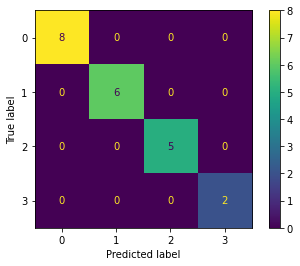

In [174]:
plot_confusion_matrix(model2, X_testt, y_testt)  

In [175]:
predictions = model2.predict(ddd)

print("Resultado", predictions)

Resultado [1]


#### SVC

In [195]:
model3= SVC().fit(X_traint, y_traint)
y_pred_test = model3.predict(X_testt)
y_pred_train = model3.predict(X_traint)

In [196]:
acc_train =  accuracy_score(y_traint,y_pred_train)
acc_test =  accuracy_score(y_testt,y_pred_test)

print('Train Accuracy: %.3f ' % acc_train)
print('Test Accuracy : %.3f' % acc_test)

Train Accuracy: 0.857 
Test Accuracy : 0.714


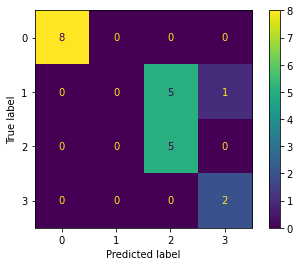

In [197]:
plot_confusion_matrix(model3, X_testt, y_testt)  

In [198]:
predictions = model3.predict(ddd)

print("Resultado", predictions)

Resultado [3]


## Outras tentativas

Tal como foi dito anteriormente, a partir deste momento não se utilizou esta secção para o resultado final.

### Feature extraction

Utilizou-se a função tsfel para extrair mais características para o nosso dataset completo. Começou-se por fazer as dataFrames individuais de cada posição, e depois concatenou-se tudo numa única DataFrame data, juntamente com as labels a indicar a classe a que cada uma pertence.

Neste passo, retirou-se em todas as dataframes resultantes a coluna do Timestamp, visto que para esta função só precisamos das amostras, da frequência de amostragem e do tamanho da janela.

In [199]:
warnings.filterwarnings("ignore")

df_D1_f = dataD1.drop("Timestamp", axis=1)[175:]
df_D2_f = dataD2.drop("Timestamp", axis=1)[116:]
df_Eq_f = dataEq.drop("Timestamp", axis=1)[150:1524]
df_Ex_f = dataEx.drop("Timestamp", axis=1)[342:]

cfg=tsfel.get_features_by_domain()

X_D1 = tsfel.time_series_features_extractor(cfg, df_D1_f, fs = 100, window_size=116)
X_D2 = tsfel.time_series_features_extractor(cfg, df_D2_f, fs = 100, window_size=100)
X_Eq = tsfel.time_series_features_extractor(cfg, df_Eq_f, fs = 100, window_size=110)
X_Ex = tsfel.time_series_features_extractor(cfg, df_Ex_f, fs = 100, window_size=108)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


#### Acrescenta-se a coluna das labelas chamada de Classe

In [200]:
#data =pd.concat([ X_D1,X_D2, X_Eq, X_Ex],  keys=["D1","D2", "Eq", "Ex"])
data =pd.concat([X_D1,X_D2, X_Eq, X_Ex])
data["Classe"]=labels

data

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,5_Wavelet variance_1,5_Wavelet variance_2,5_Wavelet variance_3,5_Wavelet variance_4,5_Wavelet variance_5,5_Wavelet variance_6,5_Wavelet variance_7,5_Wavelet variance_8,5_Zero crossing rate,Classe
0,122.429420,0.901189,122.429420,0.484067,23.0,92.0,0.160412,1.216255,0.008621,0.017241,...,0.009101,0.014211,0.021118,0.024354,0.023693,0.021641,0.020159,0.019806,35.0,1
1,89.135051,0.710431,89.135051,0.621837,23.0,92.0,0.004788,1.063026,0.008621,0.017241,...,0.025036,0.031182,0.043391,0.054688,0.059317,0.057589,0.052222,0.045805,24.0,1
2,167.530601,0.817692,167.530601,0.681605,23.0,92.0,-0.122104,1.146823,0.008621,0.017241,...,0.018141,0.024193,0.030419,0.034148,0.033796,0.030828,0.027311,0.024067,39.0,1
3,61.325461,0.549577,61.325461,0.602997,23.0,92.0,-0.292093,0.842759,0.008621,0.017241,...,0.022367,0.031063,0.046812,0.057416,0.058039,0.053422,0.048401,0.043990,32.0,1
4,60.877645,0.534350,60.877645,0.616793,23.0,92.0,-0.162806,0.802058,0.008621,0.017241,...,0.018294,0.044761,0.069657,0.073629,0.059953,0.043190,0.032776,0.029062,34.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,100.235133,1.029758,100.235133,0.535767,21.0,86.0,-0.979228,-0.945710,0.009259,0.018519,...,0.000013,0.000017,0.000020,0.000024,0.000029,0.000032,0.000034,0.000033,55.0,0
21,105.728599,1.058261,105.728599,0.530929,21.0,86.0,-1.012747,-0.964863,0.009259,0.018519,...,0.000024,0.000022,0.000019,0.000017,0.000016,0.000017,0.000018,0.000020,41.0,0
22,103.875997,1.049163,103.875997,0.536362,21.0,86.0,-1.005565,-0.962469,0.009259,0.018519,...,0.000011,0.000013,0.000014,0.000015,0.000014,0.000012,0.000010,0.000009,48.0,0
23,105.047905,1.054933,105.047905,0.531215,21.0,86.0,-1.007959,-0.964863,0.009259,0.018519,...,0.000015,0.000017,0.000024,0.000032,0.000037,0.000036,0.000031,0.000023,45.0,0


In [201]:
y=data["Classe"]

## Machine Learning

Aqui serão então aplicados alguns modelos de Machine Learning para se tentar classificar o mais corretamente possível as 4 posições que se viu anteriormente.

In [202]:
data2=data.drop(columns="Classe")

#### Verificou-se a existência de colunas com valores NaN devido ao número de características extraídas não ser igual para todos os conjuntos de movimentos, por isso retiraram-se essas mesmas colunas

In [203]:
np.any(np.isnan(data))

True

In [204]:
data.isnull().sum().sum()

1488

In [205]:
ds = data.isin([np.inf, -np.inf])
count = np.isinf(data).values.sum()
print("It contains " + str(count) + " infinite values")

It contains 0 infinite values


In [206]:
data2 = data.dropna(axis=1)

In [207]:
data2.shape

(63, 1111)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.7
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (63, 1111)
    Some column names had special characters which were removed...
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
################################################

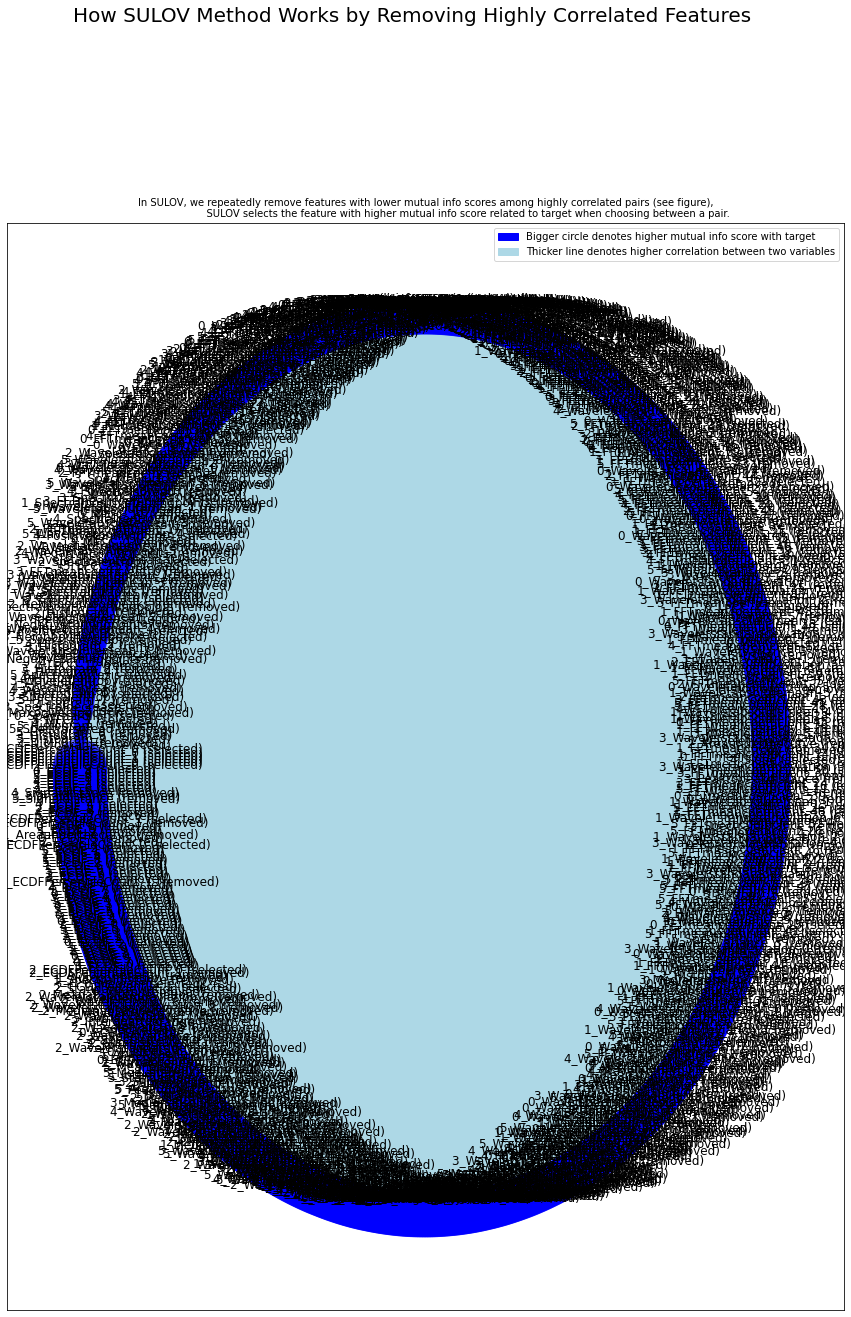

Time taken for SULOV method = 17 seconds
    Adding 0 categorical variables to reduced numeric variables  of 433
Finally 433 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 433 
    Taking top 164 features per iteration...
    XGBoost version using 1.7.2 as tree method: hist
Number of booster rounds = 100
        using 433 variables...
            selecting 3 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds
        using 346 variables...
            selecting 3 features in this iteration
            Time taken for regular XGBoost feature selection = 0 sec

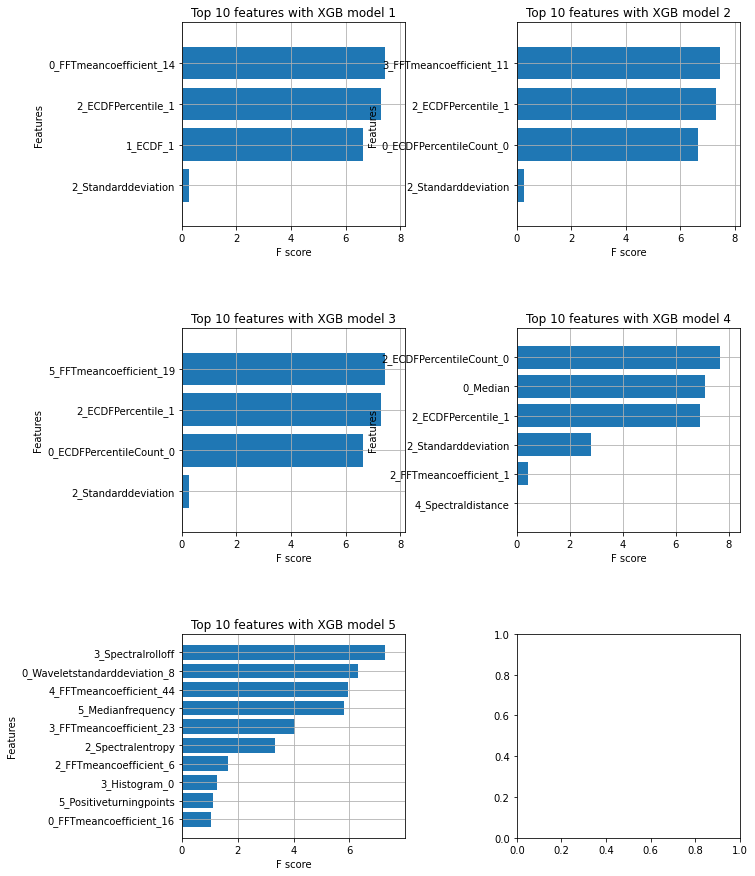

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 19 important features:
['0_FFTmeancoefficient_14', '2_ECDFPercentile_1', '1_ECDF_1', '3_FFTmeancoefficient_11', '0_ECDFPercentileCount_0', '5_FFTmeancoefficient_19', '2_ECDFPercentileCount_0', '0_Median', '2_Standarddeviation', '3_Spectralrolloff', '0_Waveletstandarddeviation_8', '4_FFTmeancoefficient_44', '5_Medianfrequency', '3_FFTmeancoefficient_23', '2_Spectralentropy', '2_FFTmeancoefficient_6', '3_Histogram_0', '5_Positiveturningpoints', '0_FFTmeancoefficient_16']
Total Time taken for featurewiz selection = 20 seconds
Output contains a list of 19 important features and a train dataframe


In [208]:
target="Classe"
features_final, train = FW.featurewiz(dataname=data2, target=target, corr_limit=0.70, verbose=2, sep=",",
                                     header=0, test_data='', feature_engg='', category_encoders='',
                                     dask_xgboost_flag=False, nrows=None)

In [212]:
#Esta é a lista com os nomes das features utilizadas no modelo, retirando algumas que parecem dar problemas em alguns datasets
ff=['2_ECDF Percentile_1',
 '1_ECDF_1',
 '0_ECDF Percentile Count_0',
 '2_ECDF Percentile Count_0',
 '0_Median',
 '2_Standard deviation',
 '3_Spectral roll-off',
 '0_Wavelet standard deviation_8',
  '5_Median frequency',
 '2_Spectral entropy',
  '3_Histogram_0',
 '5_Positive turning points']
len(ff)

12

In [211]:
train3=train.drop(columns="Classe")
train3=train3[ff]
train3

,2_ECDF Percentile_1,1_ECDF_1,0_ECDF Percentile Count_0,2_ECDF Percentile Count_0,0_Median,2_Standard deviation,3_Spectral roll-off,0_Wavelet standard deviation_8,5_Median frequency,2_Spectral entropy,3_Histogram_0,5_Positive turning points
0,1.848324,0.017241,23.0,23.0,0.776918,1.488564,47.368421,1.399586,21.929825,0.568628,0.0,32.0
1,1.211466,0.017241,23.0,23.0,0.511162,0.945193,47.368421,1.276204,20.175439,0.590393,0.0,29.0
2,1.941698,0.017241,23.0,23.0,0.511162,1.130218,45.614035,0.996205,27.192982,0.663156,2.0,29.0
3,1.843535,0.017241,23.0,23.0,0.289698,0.946084,46.491228,1.036391,15.789474,0.614371,0.0,26.0
4,1.833959,0.017241,23.0,23.0,0.363919,0.955539,42.982456,1.031128,19.298246,0.702631,1.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20,1.455675,0.018519,21.0,21.0,-0.963666,0.064401,44.339623,0.548499,17.924528,0.795244,0.0,30.0
21,1.508347,0.018519,21.0,21.0,-0.991200,0.072657,46.226415,0.541347,16.981132,0.695215,0.0,25.0
22,1.517924,0.018519,21.0,21.0,-0.979228,0.063450,48.113208,0.550483,18.867925,0.708010,0.0,31.0
23,1.601721,0.018519,21.0,21.0,-0.985214,0.070893,46.226415,0.560843,17.924528,0.502136,0.0,26.0


#### Fez-se a divisão dos dados em treino e teste

In [213]:
X_train, X_test, y_train, y_test = train_test_split(train3, y, test_size=0.33, random_state=42)

### Correlação de Pearson

Inicialmente fez-se a correlação de Pearson, mas devido à dificuldade em se perceber quais seriam exatamente as features escolhidas no final, de forma a se poder depois selecionar exatamente as mesmas nos novos dados de teste, acabou por se utilizar apenas o featurewiz.

Uma vez que se tem um número demasiado grande de features (de momento, 1100), vai-se ver quantas destas estão correlacionadas acima de um certo valor (90% por exemplo), de forma a que depois se possa retirar as mesmas, e ficar com um número de características menor.

In [217]:
corr_pearson = X_train.corr()

In [218]:
def corr_heatmap(corr):
    plt.figure(figsize=(16,14))
    sns.heatmap(data=corr, cmap=plt.cm.Reds, vmin=-1, vmax=1)
    
#plt.show(corr_heatmap(corr_pearson))

In [219]:
def correlated_features(corr_matrix, threshold):
    
    # Absolute value
    corr_matrix = corr_matrix.abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find index and column name of features with correlation greater than threshold
    corr_features = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return corr_features

In [220]:
corr_features = correlated_features(corr_pearson, threshold=0.7)
print('No. correlated features', len(corr_features))
corr_features

No. correlated features 2


['0_ECDF Percentile Count_0', '5_Median frequency']

Agora vai-se treinar o modelo sem as características correlacionadas

In [221]:
print("# Features", np.shape(X_train)[1])

X_train_corr = X_train.drop(corr_features, axis=1)
X_test_corr = X_test.drop(corr_features, axis=1)

print("# Features", np.shape(X_train_corr)[1])
print("# Features", np.shape(X_test_corr)[1])

# Features 12
# Features 10
# Features 10


### Modelos de classificação

Aplicação de vários modelos 

In [281]:
from sklearn.model_selection import cross_val_score
def classifiermetrics(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    
    train_score = classifier.score(X_train, y_train)
    test_score = classifier.score(X_test, y_test)
    
    kfold_score = cross_val_score(classifier, X_train, y_train)
    mean = np.mean(kfold_score)
    std = np.std(kfold_score)
    
    return {"Train Score" : train_score, "Test Score" : test_score, "mean" : mean, "standard deviation" : std}

#### Os modelos utilizando apenas as 42 features selecionadas pelo PCA não têm bons resultados iremos por isso utilizar as features resultantes do FFS

In [222]:
dfc=pd.DataFrame()
for name, model in models:
    d = classifiermetrics(model, X_train, y_train, X_test, y_test)
    d["clf name"] = name
    dfc = dfc.append(d, ignore_index = True)
dfc

,Train Score,Test Score,mean,standard deviation,clf name
0,0.404762,0.380952,0.405556,0.059187,Support Vector Classification
1,1.000000,1.000000,0.952778,0.058002,Naive Bayes
2,1.000000,0.952381,1.000000,0.000000,Decision trees
3,1.000000,1.000000,1.000000,0.000000,Random Forest


##### Aplicação do classificador Random Forest

In [223]:
def train_test_classifier(X_train, y_train, X_test, y_test):
    
    model4 = RandomForestClassifier()
    
    model4.fit(X_train, y_train)
    
    y_train_pred = model4.predict(X_train)
    y_test_pred = model4.predict(X_test)
    
    print("Performance:")
    print("\tTrain Accuracy:", accuracy_score(y_train, y_train_pred))    
    print("\tTest Accuracy:", accuracy_score(y_test, y_test_pred))


In [224]:
train_test_classifier(X_train, y_train, X_test, y_test)

Performance:
	Train Accuracy: 1.0
	Test Accuracy: 1.0


In [227]:
from sklearn.metrics import classification_report

model4 = RandomForestClassifier()
model4.fit(X_train, y_train)
y_test_pred = model4.predict(X_test)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [228]:
y_train_pred = model4.predict(X_train)

print('Train Accuracy: %.3f ' % accuracy_score(y_train_pred, y_train))
print('Test Accuracy : %.3f' % accuracy_score(y_test_pred, y_test))

Train Accuracy: 1.000 
Test Accuracy : 1.000


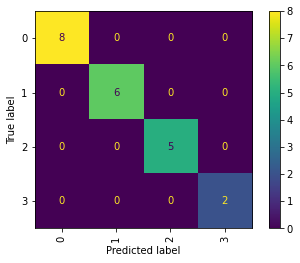

In [230]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, xticks_rotation="vertical")

##### Teste

In [231]:
ff

['2_ECDF Percentile_1',
 '1_ECDF_1',
 '0_ECDF Percentile Count_0',
 '2_ECDF Percentile Count_0',
 '0_Median',
 '2_Standard deviation',
 '3_Spectral roll-off',
 '0_Wavelet standard deviation_8',
 '5_Median frequency',
 '2_Spectral entropy',
 '3_Histogram_0',
 '5_Positive turning points']

In [232]:
data_t2 = pd.read_csv("D2_1.csv", header=None)
data_t2.columns = ["Timestamp", "Accx", "Accy", "Accz", "Gyrox", "Gyroy", "Gyroz"]
data_t2=data_t2.drop("Timestamp", axis=1)

In [233]:
data_t3 = pd.read_csv("Ex_1.csv", header=None)
data_t3.columns = ["Timestamp", "Accx", "Accy", "Accz", "Gyrox", "Gyroy", "Gyroz"]
data_t3=data_t3.drop("Timestamp", axis=1)

In [234]:
data_t4 = pd.read_csv("D1_1.csv", header=None)
data_t4.columns = ["Timestamp", "Accx", "Accy", "Accz", "Gyrox", "Gyroy", "Gyroz"]
data_t4=data_t4.drop("Timestamp", axis=1)

In [237]:
w_features_teste2 = tsfel.time_series_features_extractor(cfg, data_t2, fs = 100)
w_features_teste3 = tsfel.time_series_features_extractor(cfg, data_t3, fs = 100)
w_features_teste4 = tsfel.time_series_features_extractor(cfg, data_t4, fs = 100)

*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***


E aqui se percebe o problema do tsfel. Em cada um dos datasets é retiado um conjunto diferente de características.Não sabemos a causa de tal fenómeno, mas tendo em conta que isto acontece, decidimos simplesmente não usar este método, utilizando em vez disso as características extraídas à mão.

In [238]:
w_features_teste2

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,5_Wavelet variance_0,5_Wavelet variance_1,5_Wavelet variance_2,5_Wavelet variance_3,5_Wavelet variance_4,5_Wavelet variance_5,5_Wavelet variance_6,5_Wavelet variance_7,5_Wavelet variance_8,5_Zero crossing rate
0,53.300907,0.576165,53.300907,0.360571,17.0,71.0,0.308852,0.828394,0.011236,0.022472,...,0.003028,0.007713,0.013638,0.022958,0.033088,0.040242,0.043359,0.042852,0.039568,31.0


In [239]:
w_features_teste3

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,5_Wavelet variance_0,5_Wavelet variance_1,5_Wavelet variance_2,5_Wavelet variance_3,5_Wavelet variance_4,5_Wavelet variance_5,5_Wavelet variance_6,5_Wavelet variance_7,5_Wavelet variance_8,5_Zero crossing rate
0,1.177778,0.048339,1.177778,0.101302,4.0,17.0,0.205901,0.246603,0.045455,0.090909,...,0.000002,0.000004,0.000005,0.000009,0.000013,0.000014,0.000014,0.000014,0.000013,1.0


In [240]:
w_features_teste4

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,5_Wavelet variance_0,5_Wavelet variance_1,5_Wavelet variance_2,5_Wavelet variance_3,5_Wavelet variance_4,5_Wavelet variance_5,5_Wavelet variance_6,5_Wavelet variance_7,5_Wavelet variance_8,5_Zero crossing rate
0,241.63701,1.340861,241.63701,0.444982,18.0,72.0,1.017536,1.790863,0.011111,0.022222,...,0.005847,0.009668,0.012901,0.013558,0.015519,0.02152,0.029576,0.037659,0.044496,22.0


In [241]:
new2=w_features_teste2[ff]
new2

,2_ECDF Percentile_1,1_ECDF_1,0_ECDF Percentile Count_0,2_ECDF Percentile Count_0,0_Median,2_Standard deviation,3_Spectral roll-off,0_Wavelet standard deviation_8,5_Median frequency,2_Spectral entropy,3_Histogram_0,5_Positive turning points
0,0.299275,0.022472,17.0,17.0,0.658405,1.789801,43.023256,0.954528,12.790698,0.409364,2.0,23.0


In [242]:
new3=w_features_teste3[ff]
new3

,2_ECDF Percentile_1,1_ECDF_1,0_ECDF Percentile Count_0,2_ECDF Percentile Count_0,0_Median,2_Standard deviation,3_Spectral roll-off,0_Wavelet standard deviation_8,5_Median frequency,2_Spectral entropy,3_Histogram_0,5_Positive turning points
0,-1.805228,0.090909,4.0,4.0,0.234632,0.054662,35.0,0.105062,5.0,0.76966,0.0,5.0


In [243]:
new4=w_features_teste4[ff]
new4

,2_ECDF Percentile_1,1_ECDF_1,0_ECDF Percentile Count_0,2_ECDF Percentile Count_0,0_Median,2_Standard deviation,3_Spectral roll-off,0_Wavelet standard deviation_8,5_Median frequency,2_Spectral entropy,3_Histogram_0,5_Positive turning points
0,1.27611,0.022222,18.0,18.0,1.556231,2.334726,45.454545,1.743546,17.045455,0.388178,3.0,25.0


In [244]:
predictions = model.predict(new3)
print(predictions)

[2]
